In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
data = pd.read_csv('../data/preprocessed_data_a.csv')
data.head()

,sex,age,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control,...,Lowest SaO2 (%),ODI,90%ODI,EtCO2 (>50mmHg),Total LMI =PLMI(/h),Total LM Arousal#,Total LM AI(/h),PLM Arousal#,PLM AI(/h),MAI(/h)
0,1,55,1,0,0,0,0,0,0,0,...,88.0,0.0,0.0,0.0,3.2,2.0,0.3,0.0,0.0,0.3
1,0,48,1,0,0,0,0,0,0,0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,55,1,0,0,0,0,0,0,0,...,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,50,1,0,0,0,0,0,0,0,...,83.0,0.0,0.0,0.0,46.8,0.0,0.0,0.0,0.0,0.0
4,0,57,1,0,0,0,0,0,0,0,...,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [5]:
def cm_labels(cm):
    label_names = ['TN', 'FP', 'FN', 'TP']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{ln}\n{c}\n{p}" for ln, c, p in zip(label_names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    return labels

In [6]:
def eval_metrics(y_test, title='Confusion Matrix', pred=None, pred_proba=None, multilabel=False):
    target_names = list(y_test.columns)    
    if multilabel:
        if len(pred.shape) == 1:
            num = np.unique(y_pred, axis=0)
            num = num.shape[0]
            pred_converted = np.eye(num)[pred]
            pred = pred_converted

        total_accuracy = accuracy_score(y_test, pred)
        print(f'total accuracy: {total_accuracy}')
        
        accuracy_dict = {}
        for i, y in enumerate(y_test.columns):
            accuracy = accuracy_score(y_test[y], pred[:, i])
            accuracy_dict[y] = accuracy
            print(f'{y} accuracy: {accuracy}')
        
        fig1, axes1 = plt.subplots(2, 2, figsize=(17, 17))
        fig2, axes2 = plt.subplots(2, 2, figsize=(17, 17))

        axes_list1 = [ax for sublist in axes1 for ax in sublist]
        axes_list2 = [ax for sublist in axes2 for ax in sublist]
        flattend_axes = axes_list1 + axes_list2

        cms = multilabel_confusion_matrix(y_test, pred)
        for i, ax in enumerate(flattend_axes):
            labels = cm_labels(cms[i])
            sns.heatmap(cms[i], annot=labels, fmt='', cmap='Blues', ax=ax).set(title=f'{title} - {target_names[i]}')
    else:
        accuracy = accuracy_score(y_test, pred)
        print(f'accuracy: {accuracy}')
        
        cm = confusion_matrix(y_test, pred)
        labels = cm_labels(cm)
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax).set(title=title)
    
    print(classification_report(y_test, pred, target_names=target_names))
    plt.show()
    
    report_dict = classification_report(y_test, pred, target_names=target_names, output_dict=True)
    
    for k, v in accuracy_dict.items():
        report_dict[k]['accuracy'] = v
    
    report_dict['total accuracy'] = total_accuracy
    return report_dict

In [7]:
target = data.iloc[:, 2:10]
features = data.drop(data.iloc[:, 2:10], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
y_train_converted = y_train.apply(lambda y: y.argmax(), axis=1).values

In [8]:
params_dict = {
    'estimator__solver': ['sgd', 'adam'],
    'estimator__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'estimator__activation': ['logistic', 'tanh', 'relu'],
    'estimator__alpha': [0.00001, 0.0001, 0.001, 0.01],
    'estimator__learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier(random_state=42)

grid_mlp0 = GridSearchCV(MultiOutputClassifier(mlp, n_jobs=4), params_dict, cv=3, refit=True)
grid_mlp0.fit(X_train, y_train)

print(grid_mlp0.best_params_)
print(grid_mlp0.best_score_)

/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/min

/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/min

/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyewonhan/min

{'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (100,), 'estimator__learning_rate': 'constant', 'estimator__solver': 'adam'}
0.7113144758735442


total accuracy: 0.6998706338939198
OSA accuracy: 0.9178525226390686
insomnia accuracy: 0.9204398447606728
PLMD, RLS accuracy: 0.9010349288486417
parasomnia accuracy: 0.961836998706339
circadian rhythm sleep-wake disorder accuracy: 0.981888745148771
Narcolepsy, EDS, Hypersomnia accuracy: 0.9760672703751617
Catathrenia accuracy: 0.999353169469599
control accuracy: 0.9372574385510997


/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.95      0.94      0.94      1143
                            insomnia       0.66      0.33      0.44       146
                           PLMD, RLS       0.63      0.41      0.50       184
                          parasomnia       0.00      0.00      0.00        59
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        28
        Narcolepsy, EDS, Hypersomnia       0.00      0.00      0.00        37
                         Catathrenia       0.00      0.00      0.00         1
                             control       0.67      0.53      0.59       133

                           micro avg       0.89      0.73      0.80      1731
                           macro avg       0.36      0.28      0.31      1731
                        weighted avg       0.80      0.73      0.76      1731
                         samples avg       0.79      0.76     

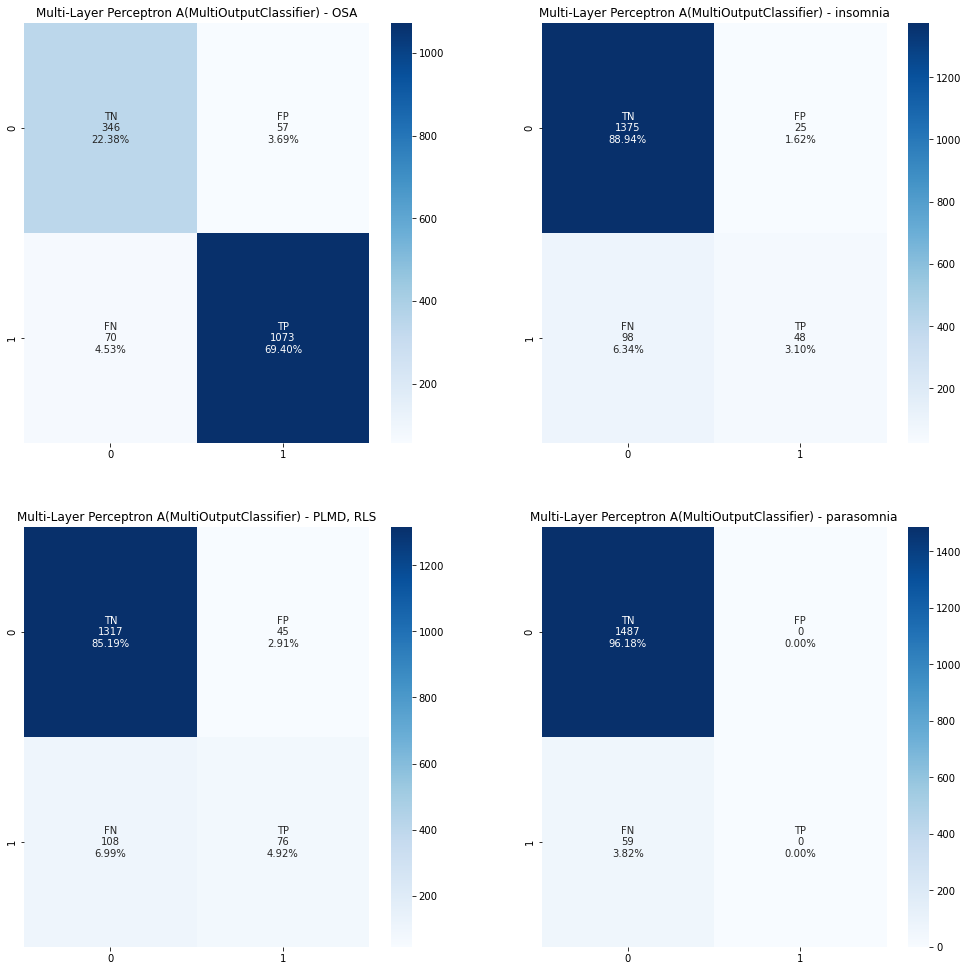

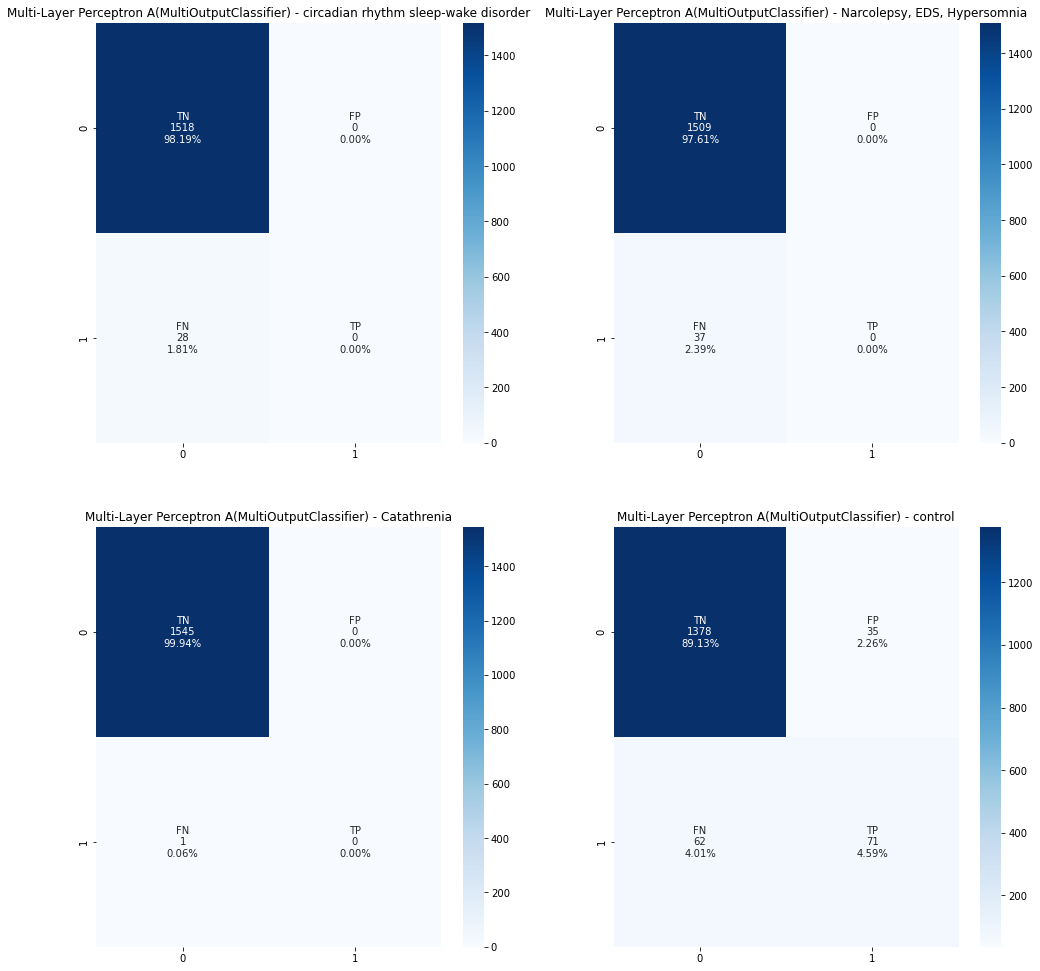

/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
y_pred = grid_mlp0.best_estimator_.predict(X_test)
y_pred_proba = grid_mlp0.best_estimator_.predict_proba(X_test)

res = eval_metrics(y_test, title='Multi-Layer Perceptron A(MultiOutputClassifier)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

In [31]:
import gspread

gc = gspread.service_account(filename='../credentials.json')
wks = gc.open_by_key("10jJBC4Ff_pgi8FIwxsRRIPHNCi4gswteyyyUsqWCMGw").sheet1

In [11]:
for key in res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+21, cell.col, res[key])
        continue
        
    scores = res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+21, cell.col, score)

[<Cell R1C5 'Accuracy_OSA'>, <Cell R1C13 'Precision_OSA'>, <Cell R1C25 'Recall_OSA'>, <Cell R1C37 'F1_OSA'>]
[<Cell R1C6 'Accuracy_insomnia'>, <Cell R1C14 'Precision_insomnia'>, <Cell R1C26 'Recall_insomnia'>, <Cell R1C38 'F1_insomnia'>]
[<Cell R1C7 'Accuracy_PLMD,RLS'>, <Cell R1C15 'Precision_PLMD,RLS'>, <Cell R1C27 'Recall_PLMD,RLS'>, <Cell R1C39 'F1_PLMD,RLS'>]
[<Cell R1C8 'Accuracy_parasomnia'>, <Cell R1C16 'Precision_parasomnia'>, <Cell R1C28 'Recall_parasomnia'>, <Cell R1C40 'F1_parasomnia'>]
[<Cell R1C9 'Accuracy_circadian'>, <Cell R1C17 'Precision_circadian'>, <Cell R1C29 'Recall_circadian'>, <Cell R1C41 'F1_circadian'>]
[<Cell R1C10 'Accuracy_Narcolepsy,EDS,Hypersomnia'>, <Cell R1C18 'Precision_Narcolepsy,EDS,Hypersomnia'>, <Cell R1C30 'Recall_Narcolepsy,EDS,Hypersomnia'>, <Cell R1C42 'F1_Narcolepsy,EDS,Hypersomnia'>]
[<Cell R1C11 'Accuracy_Catathrenia'>, <Cell R1C19 'Precision_Catathrenia'>, <Cell R1C31 'Recall_Catathrenia'>, <Cell R1C43 'F1_Catathrenia'>]
[<Cell R1C12 'Accur

In [13]:
mlp = MLPClassifier(
    solver=grid_mlp0.best_params_['estimator__solver'],
    activation=grid_mlp0.best_params_['estimator__activation'],
    alpha=grid_mlp0.best_params_['estimator__alpha'],
    learning_rate=grid_mlp0.best_params_['estimator__learning_rate'],
    hidden_layer_sizes=grid_mlp0.best_params_['estimator__hidden_layer_sizes'],
    random_state=42
)

chain_mlp0 = ClassifierChain(mlp, order='random', random_state=42)
chain_mlp0.fit(X_train, y_train)

ClassifierChain(base_estimator=MLPClassifier(activation='logistic',
                                             random_state=42),
                order='random', random_state=42)

total accuracy: 0.7082794307891332
OSA accuracy: 0.9139715394566623
insomnia accuracy: 0.9191461836998707
PLMD, RLS accuracy: 0.8990944372574385
parasomnia accuracy: 0.961836998706339
circadian rhythm sleep-wake disorder accuracy: 0.981888745148771
Narcolepsy, EDS, Hypersomnia accuracy: 0.9760672703751617
Catathrenia accuracy: 0.999353169469599
control accuracy: 0.9366106080206986


/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.93      0.96      0.94      1143
                            insomnia       0.76      0.21      0.33       146
                           PLMD, RLS       0.59      0.49      0.54       184
                          parasomnia       0.00      0.00      0.00        59
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        28
        Narcolepsy, EDS, Hypersomnia       0.00      0.00      0.00        37
                         Catathrenia       0.00      0.00      0.00         1
                             control       0.65      0.57      0.61       133

                           micro avg       0.87      0.75      0.80      1731
                           macro avg       0.37      0.28      0.30      1731
                        weighted avg       0.79      0.75      0.75      1731
                         samples avg       0.80      0.77     

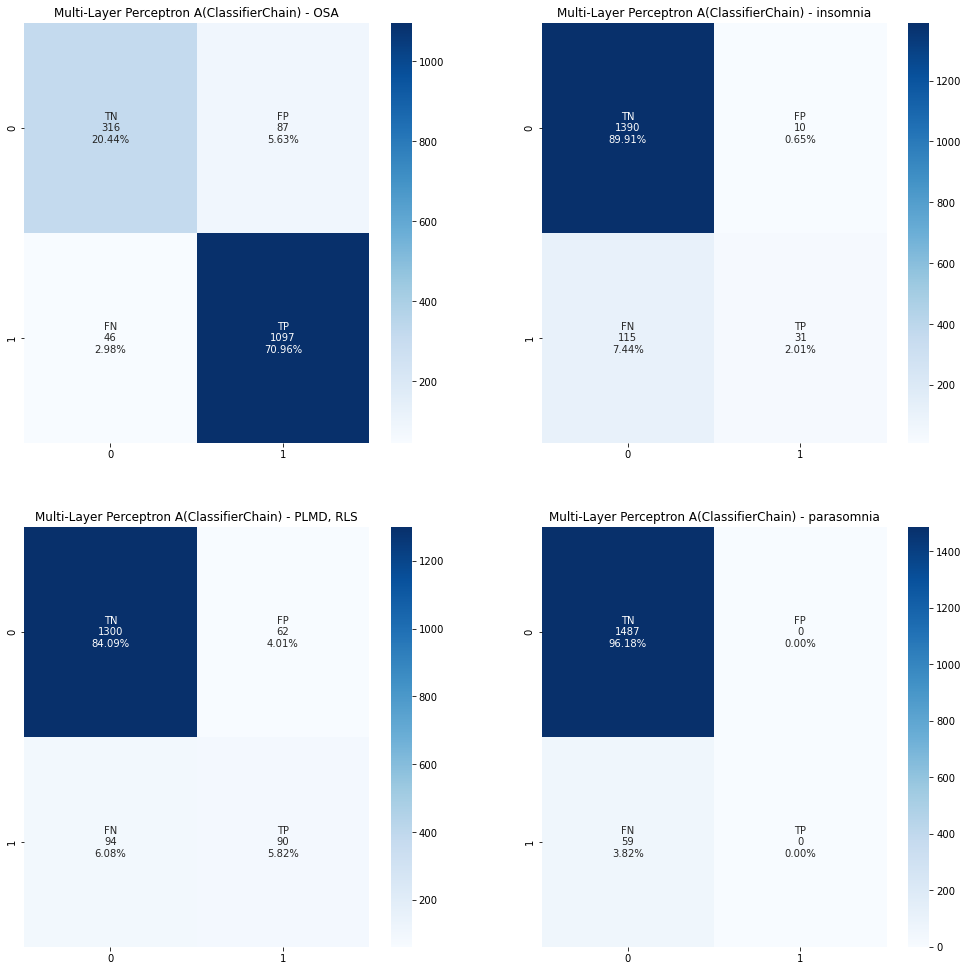

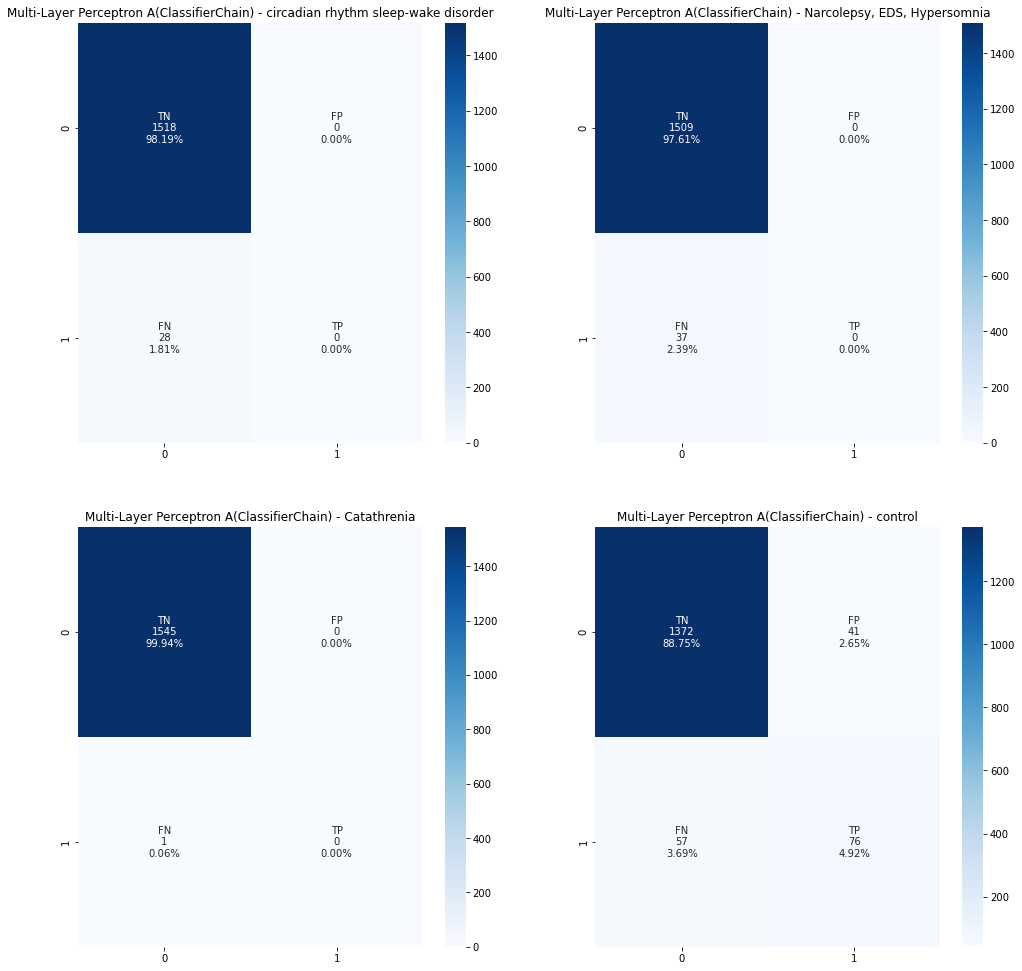

/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
y_pred = chain_mlp0.predict(X_test)
y_pred_proba = chain_mlp0.predict_proba(X_test)

res = eval_metrics(y_test, title='Multi-Layer Perceptron A(ClassifierChain)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

In [25]:
for key in res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+3, cell.col, res[key])
        continue
        
    scores = res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+3, cell.col, score)

In [17]:
params_dict = {
    'estimator__hidden_layer_sizes': [(1024, 512, 8)],
    'estimator__activation': ['logistic', 'relu'],
    'estimator__alpha': [0.00001, 0.0001, 0.001],
    'estimator__learning_rate': ['constant', 'adaptive'],
}

mlp = MLPClassifier(max_iter=10000, random_state=42)

grid_mlp0 = GridSearchCV(MultiOutputClassifier(mlp, n_jobs=4), params_dict, cv=3, refit=True)
grid_mlp0.fit(X_train, y_train)

print(grid_mlp0.best_params_)
print(grid_mlp0.best_score_)

{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (1024, 512, 8), 'estimator__learning_rate': 'constant'}
0.7093732667775928


total accuracy: 0.6875808538163001
OSA accuracy: 0.9133247089262613
insomnia accuracy: 0.9172056921086675
PLMD, RLS accuracy: 0.8861578266494179
parasomnia accuracy: 0.9586028460543338
circadian rhythm sleep-wake disorder accuracy: 0.981888745148771
Narcolepsy, EDS, Hypersomnia accuracy: 0.9780077619663649
Catathrenia accuracy: 0.999353169469599
control accuracy: 0.9294954721862871


/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.93      0.96      0.94      1143
                            insomnia       0.60      0.36      0.45       146
                           PLMD, RLS       0.52      0.64      0.57       184
                          parasomnia       0.44      0.29      0.35        59
circadian rhythm sleep-wake disorder       0.00      0.00      0.00        28
        Narcolepsy, EDS, Hypersomnia       0.64      0.19      0.29        37
                         Catathrenia       0.00      0.00      0.00         1
                             control       0.69      0.32      0.44       133

                           micro avg       0.83      0.77      0.80      1731
                           macro avg       0.48      0.34      0.38      1731
                        weighted avg       0.80      0.77      0.77      1731
                         samples avg       0.79      0.79     

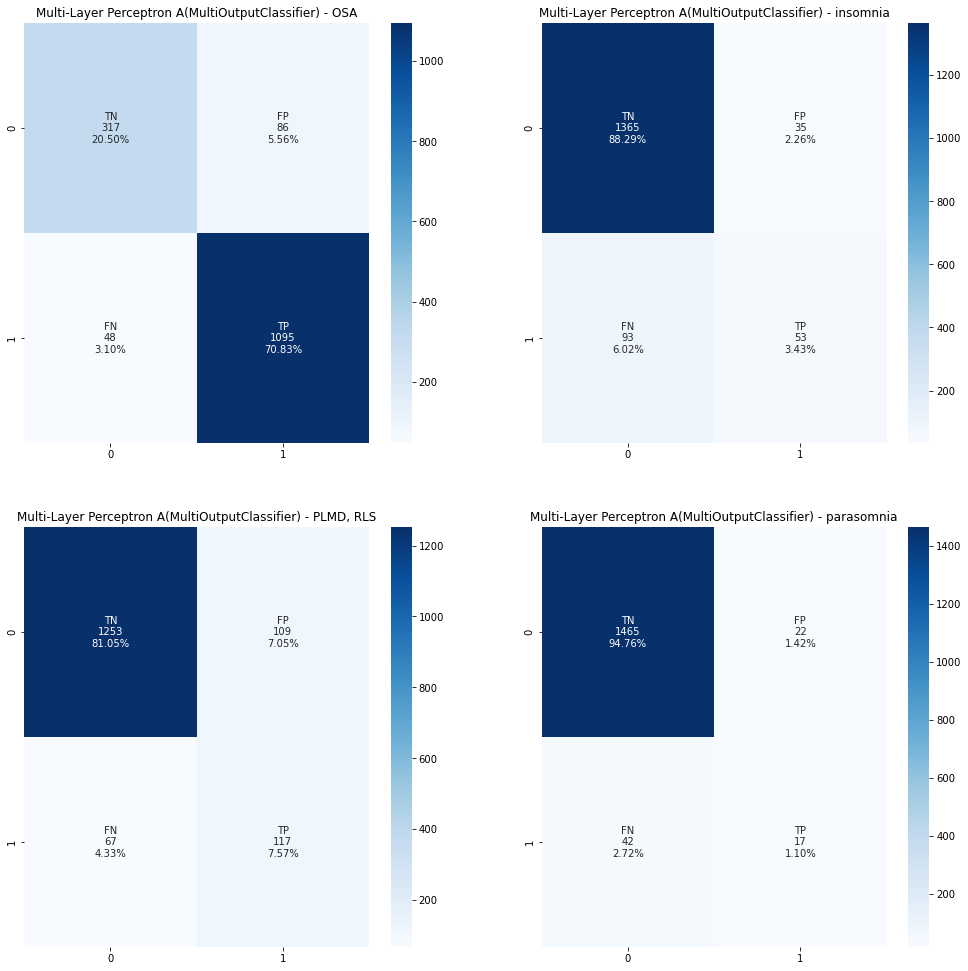

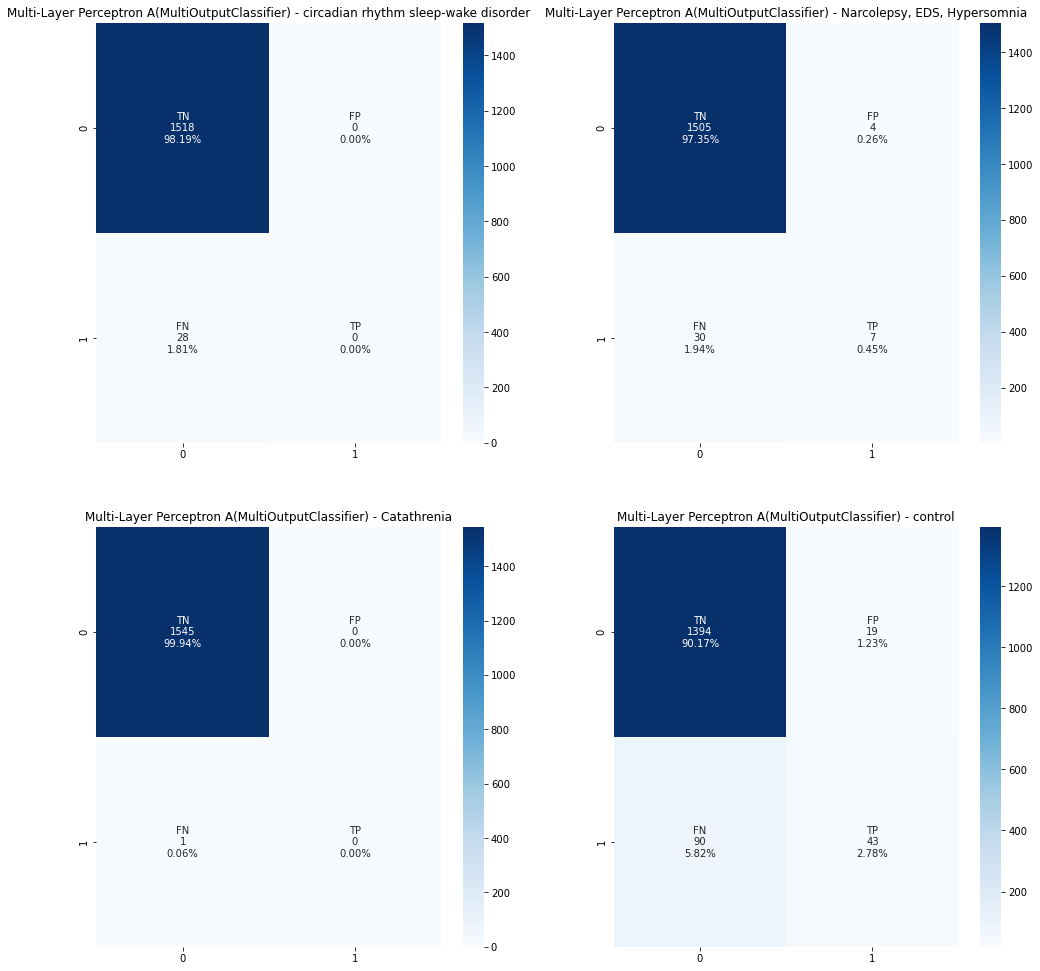

/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
y_pred = grid_mlp0.best_estimator_.predict(X_test)
y_pred_proba = grid_mlp0.best_estimator_.predict_proba(X_test)

res = eval_metrics(y_test, title='Multi-Layer Perceptron A(MultiOutputClassifier)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

In [23]:
for key in res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+2, cell.col, res[key])
        continue
        
    scores = res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+2, cell.col, score)

In [26]:
mlp = MLPClassifier(
    max_iter=10000,
    activation=grid_mlp0.best_params_['estimator__activation'],
    alpha=grid_mlp0.best_params_['estimator__alpha'],
    learning_rate=grid_mlp0.best_params_['estimator__learning_rate'],
    hidden_layer_sizes=grid_mlp0.best_params_['estimator__hidden_layer_sizes'],
    random_state=42
)

chain_mlp1 = ClassifierChain(mlp, order='random', random_state=42)
chain_mlp1.fit(X_train, y_train)

ClassifierChain(base_estimator=MLPClassifier(hidden_layer_sizes=(1024, 512, 8),
                                             max_iter=10000, random_state=42),
                order='random', random_state=42)

total accuracy: 0.6940491591203105
OSA accuracy: 0.9113842173350583
insomnia accuracy: 0.9172056921086675
PLMD, RLS accuracy: 0.8809831824062095
parasomnia accuracy: 0.96248382923674
circadian rhythm sleep-wake disorder accuracy: 0.9760672703751617
Narcolepsy, EDS, Hypersomnia accuracy: 0.9760672703751617
Catathrenia accuracy: 0.999353169469599
control accuracy: 0.9372574385510997


/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                                 OSA       0.91      0.98      0.94      1143
                            insomnia       0.60      0.36      0.45       146
                           PLMD, RLS       0.00      0.00      0.00       184
                          parasomnia       0.67      0.03      0.06        59
circadian rhythm sleep-wake disorder       0.26      0.18      0.21        28
        Narcolepsy, EDS, Hypersomnia       0.50      0.05      0.10        37
                         Catathrenia       0.00      0.00      0.00         1
                             control       0.68      0.50      0.58       133

                           micro avg       0.86      0.72      0.79      1731
                           macro avg       0.45      0.26      0.29      1731
                        weighted avg       0.74      0.72      0.71      1731
                         samples avg       0.80      0.76     

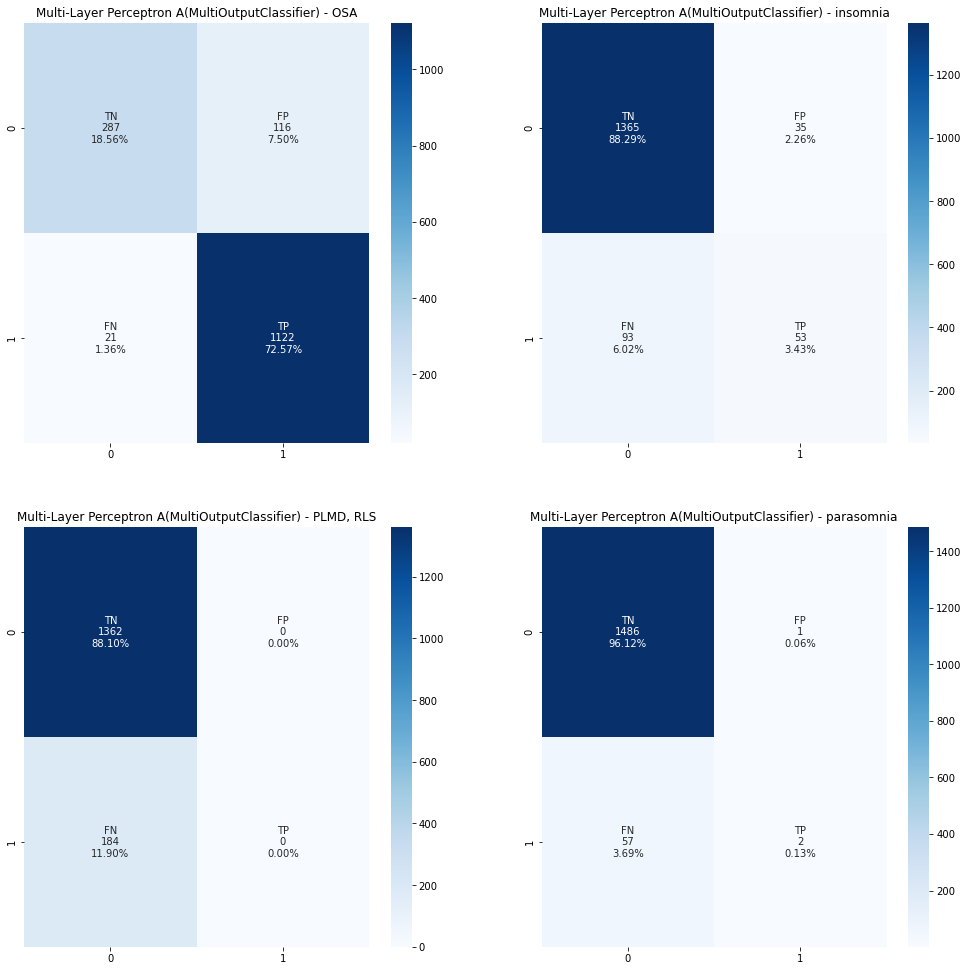

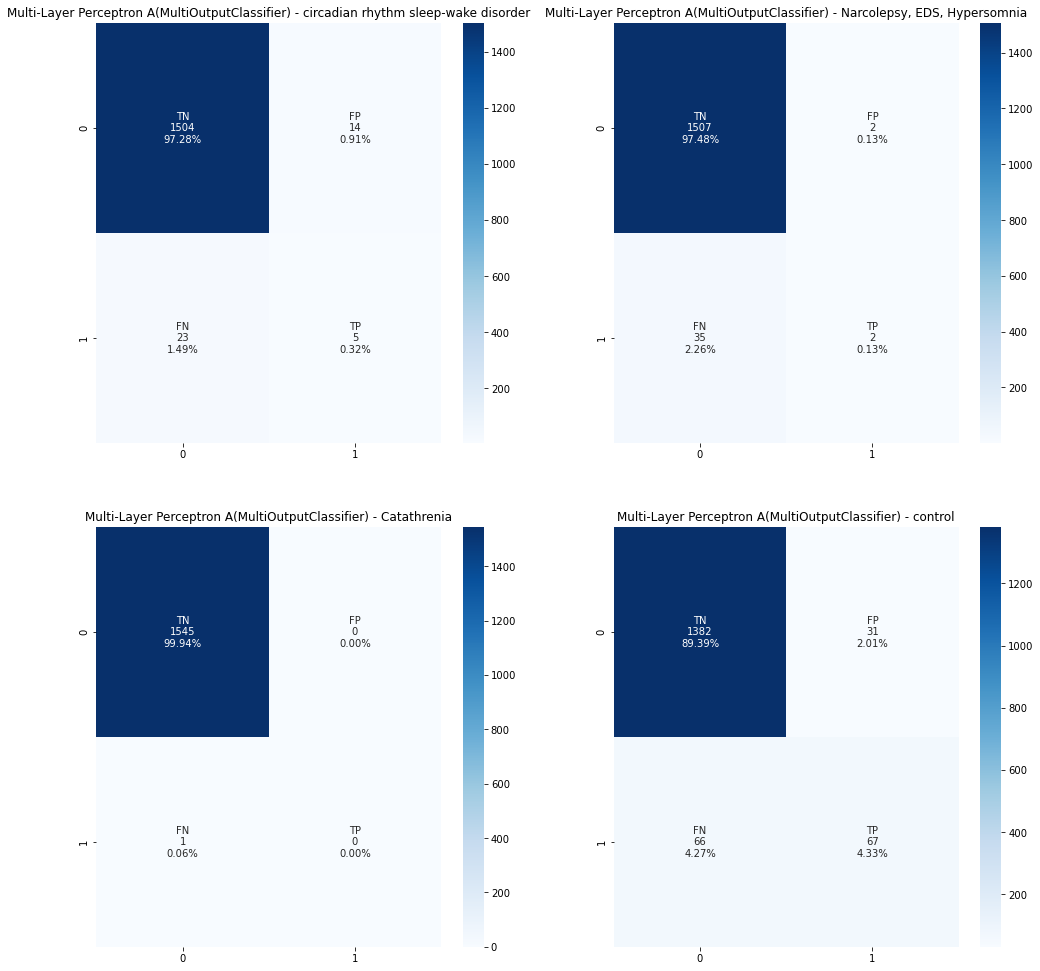

/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hyewonhan/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
y_pred = chain_mlp1.predict(X_test)
y_pred_proba = chain_mlp1.predict_proba(X_test)

res = eval_metrics(y_test, title='Multi-Layer Perceptron A(MultiOutputClassifier)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

In [32]:
for key in res.keys():
    if key == 'total accuracy':
        cell = wks.find('Total Accuracy')
        wks.update_cell(cell.row+4, cell.col, res[key])
        continue
        
    scores = res[key]
    
    if ',' in key:
        key = key.replace(', ', ',')
    elif ' ' in key:
        key = key.split(' ')[0]
    amount_re = re.compile(rf'_{key}$')
    cells = wks.findall(amount_re)

    for cell in cells:
        if 'Accuracy' in cell.value:
            score = scores['accuracy']
        elif 'Precision' in cell.value:
            score = scores['precision']
        elif 'Recall' in cell.value:
            score = scores['recall']
        elif 'F1' in cell.value:
            score = scores['f1-score']
        wks.update_cell(cell.row+4, cell.col, score)